In [1]:
import pandas as pd
import numpy as np
import pdfplumber
import os

In [2]:
# This code will read the pdf files in the pdf folder and extract the text from them
# It will output three values: the year of the debate, the title/subject of the debate, and the text of the debate

firstTime = True
for pdf_filename in os.listdir("pdf"):
    print(pdf_filename)
    pdf = pdfplumber.open("pdf/" + pdf_filename)

    pdf_text = ""
    for page in pdf.pages:
        # Divide the page into two columns and ignoring the footer
        left_box = page.within_bbox((0, 0, page.width / 2, page.height - 100))
        left_text = left_box.extract_text()
        right_box = page.within_bbox((page.width / 2, 0, page.width, page.height - 100))
        right_text = right_box.extract_text()
        
        pdf_text += left_text + right_text
        
        # Clean the data
        pdf_text = pdf_text.replace("-\n", "")

    first_page = pdf.pages[0]
    year_box = first_page.within_bbox((first_page.width / 2, first_page.height - 100, first_page.width, first_page.height - 70))
    year_text = year_box.extract_text()

    # print(pdf_text)

    pdf_subject = pdf_text.split("\n")[1]

    # print(pdf_subject)
    pdf_text = pdf_text.strip().replace("\n", " ")
    #pdf_text = pdf_text.replace(",", "")

    file_name = "txt/" + pdf_filename + ".txt"
    with open(file_name, "w") as f:
        f.write(pdf_text)

    pdf_df = pd.DataFrame({"date": [year_text], "subject": [pdf_subject], "text": [file_name]})

    if firstTime:
        pdf_df.to_csv("debates.csv", index=False)
        firstTime = False
    else:
        pdf_df.to_csv("debates.csv", mode='a', header=False, index=False)

40993d1c-f887-482d-89f7-33e41f6f7ed9.pdf
ed7ffb05-ec88-44ef-a7a0-92caf70df476.pdf


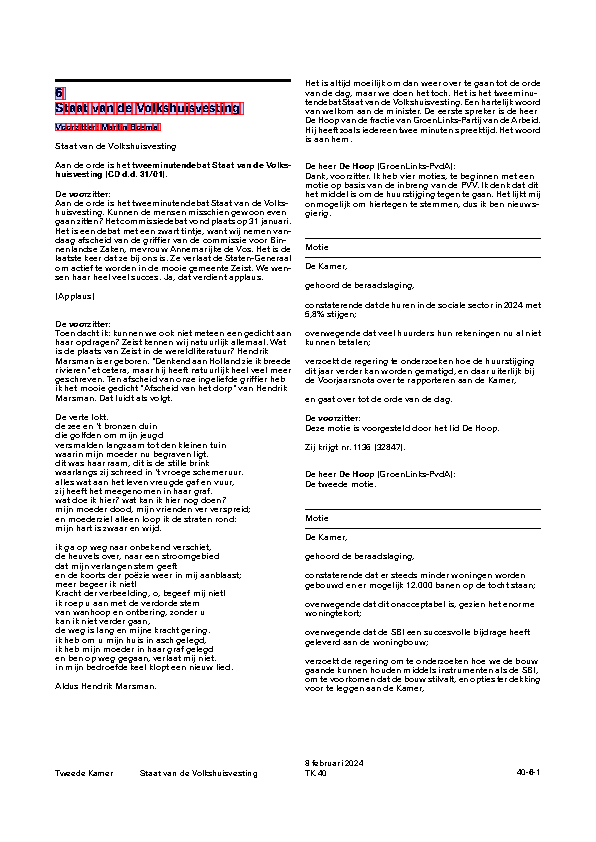

In [3]:
# This code shows how the box is drawn using the pdfplumber library

pdf = pdfplumber.open("pdf/40993d1c-f887-482d-89f7-33e41f6f7ed9.pdf")
page = pdf.pages[0]

year_box = page.within_bbox((0, 0, page.width / 2, page.height - 700))


im = page.to_image()
im.draw_rects(year_box.chars)


In [14]:
pip install python-docx

Note: you may need to restart the kernel to use updated packages.


In [16]:
import os
import pdfplumber
import xml.etree.ElementTree as ET
from xml.dom import minidom

def create_debate_xml():
    """Create the root XML element for debates"""
    root = ET.Element("debates")
    return root

def add_debate_to_xml(root, date, subject, text):
    """Add a debate entry to the XML tree"""
    debate = ET.SubElement(root, "debate")
    
    date_elem = ET.SubElement(debate, "date")
    date_elem.text = date
    
    subject_elem = ET.SubElement(debate, "subject")
    subject_elem.text = subject
    
    text_elem = ET.SubElement(debate, "text")
    text_elem.text = text
    
    return debate

# Create XML root
root = create_debate_xml()

for pdf_filename in os.listdir("pdf"):
    print(pdf_filename)
    pdf = pdfplumber.open("pdf/" + pdf_filename)

    pdf_text = ""
    for page in pdf.pages:
        # Divide the page into two columns and ignoring the footer
        left_box = page.within_bbox((0, 0, page.width / 2, page.height - 100))
        left_text = left_box.extract_text()
        right_box = page.within_bbox((page.width / 2, 0, page.width, page.height - 100))
        right_text = right_box.extract_text()
        
        pdf_text += left_text + right_text
        
        # Clean the data
        pdf_text = pdf_text.replace("-\n", "")

    first_page = pdf.pages[0]
    year_box = first_page.within_bbox((first_page.width / 2, first_page.height - 100, first_page.width, first_page.height - 70))
    year_text = year_box.extract_text()

    pdf_subject = pdf_text.split("\n")[1]
    pdf_text = pdf_text.strip().replace("\n", " ")

    # Add debate to XML
    add_debate_to_xml(root, year_text, pdf_subject, pdf_text)

# Pretty print XML and save
xmlstr = minidom.parseString(ET.tostring(root)).toprettyxml(indent="   ")
with open("debates.xml", "w", encoding="utf-8") as f:
    f.write(xmlstr)

0a178131-9bbf-4848-b528-25341b33c6cc.pdf
0a389791-784b-4688-8694-4b0027a7cec7.pdf
0a9f7faa-4b9c-4c23-a078-0e28e9afaa04.pdf
40993d1c-f887-482d-89f7-33e41f6f7ed9.pdf
ed7ffb05-ec88-44ef-a7a0-92caf70df476.pdf


In [11]:
#This one seems to work! I think it is working!
import re
import pandas as pd

def extract_speeches(text):
    """Extract individual speeches from debate text with improved speaker detection"""
    # First remove irrelevant patterns
    irrelevante_patronen = [
        r"\(Applaus\)",
        r"\(Hilariteit\)",
    ]
    
    # Remove irrelevant patterns before processing
    for pattern in irrelevante_patronen:
        text = re.sub(pattern, "", text)
    
    speeches = []
    
    # Split pattern into three parts with strict formatting rules
    # Updated to handle sentences ending in ? or !
    voorzitter_pattern = r'(?:^|\n|[.!?]\s*|[.!?])De [Vv]oorzitter\s*:'
    minister_pattern = r'(?:^|\n|[.!?]\s*|[.!?])Minister\s+[A-Za-z\-\' ]+\s*:'
    speaker_pattern = r'(?:^|\n|[.!?]\s*|[.!?])(?:De heer|Mevrouw)\s+[A-Za-z\-\' ]+\s*\([^)]+\)\s*:'
    
    # Combine patterns
    pattern = f'({voorzitter_pattern}|{minister_pattern}|{speaker_pattern})'
    
    # Split text but preserve delimiters
    parts = re.split(pattern, text)
    
    current_speaker = ""
    current_party = ""
    current_text = ""
    
    for part in parts:
        if not part.strip():
            continue
            
        # Check if this part matches speaker pattern
        if re.match(pattern, part.strip()):
            # Save previous speech if exists
            if current_speaker and current_text:
                speeches.append({
                    "speaker": current_speaker,
                    "party": current_party,
                    "text": current_text.strip()
                })
            
            # Extract new speaker info
            speaker_text = part.strip()[:-1]  # Remove colon
            
            # Check if it's voorzitter first
            if re.match(r'De [Vv]oorzitter\s*$', speaker_text.strip()):
                current_speaker = "De voorzitter"
                current_party = ""
            else:
                # Extract party if present
                party_match = re.search(r'\(([^)]+)\)', speaker_text)
                current_party = party_match.group(1) if party_match else ""
                
                # Clean speaker name
                speaker_text = re.sub(r'^[.!?]?\s*', '', speaker_text)  # Remove leading punctuation
                current_speaker = re.sub(r'^(?:De (?:heer|voorzitter)|Mevrouw|Minister)\s+', '', speaker_text)
                current_speaker = re.sub(r'\s*\([^)]+\)', '', current_speaker).strip()
            
            current_text = ""
            
        else:
            if current_speaker:  # Only add text if we have a current speaker
                # Check for embedded speaker changes
                embedded_match = re.search(r'([.!?])\s*(?:De heer|Mevrouw|De [Vv]oorzitter)\s+([A-Za-z\-\' ]+)(?:\s*\(([^)]+)\))?\s*:', part)
                if embedded_match:
                    end_punct, new_speaker, new_party = embedded_match.groups()
                    pre_text, post_text = part.split(embedded_match.group(0))
                    
                    # Save current speaker's text
                    if current_text.strip() + pre_text.strip():
                        speeches.append({
                            "speaker": current_speaker,
                            "party": current_party,
                            "text": (current_text + " " + pre_text).strip()
                        })
                    
                    # Update to new speaker
                    current_speaker = new_speaker
                    current_party = new_party
                    current_text = post_text
                else:
                    current_text += " " + part.strip()
    
    # Add final speech
    if current_speaker and current_text:
        speeches.append({
            "speaker": current_speaker,
            "party": current_party,
            "text": current_text.strip()
        })
    
    return speeches

# Parse XML file
tree = ET.parse('debates.xml')
root = tree.getroot()

all_speeches = []

# Process each debate
for debate in root.findall('debate'):
    date = debate.find('date').text
    subject = debate.find('subject').text
    text = debate.find('text').text
    
    # Extract speeches from debate text
    speeches = extract_speeches(text)
    
    # Add debate metadata to each speech
    for speech in speeches:
        speech['date'] = date
        speech['subject'] = subject
    
    all_speeches.extend(speeches)

# Create DataFrame
speeches_df = pd.DataFrame(all_speeches)
speeches_df = speeches_df[['date', 'subject', 'speaker', 'party', 'text']]

# Save to CSV
speeches_df.to_csv("speeches_new.csv", index=False)

To fix issue with handling docx files

In [1]:
#updated pdf plumber with support for docx

import os
import pdfplumber
import docx
import xml.etree.ElementTree as ET
from xml.dom import minidom

def create_debate_xml():
    """Create the root XML element for debates"""
    root = ET.Element("debates")
    return root

def add_debate_to_xml(root, date, subject, text):
    """Add a debate entry to the XML tree"""
    debate = ET.SubElement(root, "debate")
    
    date_elem = ET.SubElement(debate, "date")
    date_elem.text = date
    
    subject_elem = ET.SubElement(debate, "subject")
    subject_elem.text = subject
    
    text_elem = ET.SubElement(debate, "text")
    text_elem.text = text
    
    return debate

def extract_from_pdf(file_path):
    """Extract text and metadata from PDF file"""
    with pdfplumber.open(file_path) as pdf:
        pdf_text = ""
        for page in pdf.pages:
            # Divide the page into two columns and ignoring the footer
            left_box = page.within_bbox((0, 0, page.width / 2, page.height - 100))
            left_text = left_box.extract_text()
            right_box = page.within_bbox((page.width / 2, 0, page.width, page.height - 100))
            right_text = right_box.extract_text()
            
            pdf_text += left_text + right_text

        # Clean the data
        pdf_text = pdf_text.replace("-\n", "")
        
        # Extract date and subject
        first_page = pdf.pages[0]
        year_box = first_page.within_bbox((first_page.width / 2, first_page.height - 100, first_page.width, first_page.height - 70))
        date = year_box.extract_text()
        subject = pdf_text.split("\n")[1]
        
        # Clean final text
        text = pdf_text.strip().replace("\n", " ")
        
        return date, subject, text

def extract_from_docx(file_path):
    """Extract text and metadata from DOCX file"""
    doc = docx.Document(file_path)
    
    # Combine all paragraphs
    text = "\n".join(paragraph.text for paragraph in doc.paragraphs)
    
    # Extract date and subject (assuming same format as PDF)
    lines = text.split("\n")
    subject = lines[1] if len(lines) > 1 else ""
    
    # Try to extract date from document properties or first page
    date = ""
    if doc.core_properties.modified:
        date = doc.core_properties.modified.strftime("%d %B %Y")
    
    # Clean final text
    text = text.strip().replace("\n", " ")
    
    return date, subject, text

# Create XML root
root = create_debate_xml()

# Process both PDF and DOCX files
for filename in os.listdir("pdf"):
    file_path = os.path.join("pdf", filename)
    print(f"Processing {filename}")
    
    try:
        if filename.lower().endswith('.pdf'):
            date, subject, text = extract_from_pdf(file_path)
        elif filename.lower().endswith('.docx'):
            date, subject, text = extract_from_docx(file_path)
        else:
            print(f"Unsupported file type: {filename}")
            continue
        
        # Add debate to XML
        add_debate_to_xml(root, date, subject, text)
        
    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")

# Pretty print XML and save
xmlstr = minidom.parseString(ET.tostring(root)).toprettyxml(indent="   ")
with open("debates.xml", "w", encoding="utf-8") as f:
    f.write(xmlstr)

Processing 000299a9-e3b9-4997-9a25-4e2b00e61dca.pdf
Processing 00035a28-9a80-448e-86c3-9886aa73a9b8.pdf
Processing 003d76b1-e231-4b4c-b3c2-abbb15c2e1dc.pdf
Processing 005e351c-9a1d-416c-ba59-35460a136de4.pdf
Processing 006ea61f-8c52-4d91-87c5-ef5da4411a4d.pdf
Processing 00b11c9b-1424-42d3-aeee-b357e042687b.pdf
Processing 00b76a3e-8e8b-4cbe-ab3d-8ba4ea9404ff.pdf
Processing 00b786eb-afed-48d1-a170-fd385ec7942b.pdf
Processing 00bc30d8-bb3e-497f-b93a-86fb28259314.pdf
Processing 00e8a26a-ee73-427d-9a0c-09d3f58c8662.pdf
Processing 01302b8e-7c7f-449a-9f44-575ece2267cc.pdf
Processing 014ea50e-fc34-4556-bc94-2aa11700eec9.pdf
Processing 0151f0ad-8dbd-4a09-af13-4dd6af3e5a6f.pdf
Processing 0157e63b-ed31-46da-9614-98d7030cd10b.pdf
Processing 0178a7af-1fda-4c42-8f80-1ae2b1cd59ee.pdf
Processing 019d3752-94bc-4586-9ae8-23b713989f45.pdf
Processing 01aeb7a7-eef8-42a9-87fd-a088518abd3a.docx
Processing 01dfe46e-a353-42ee-82ae-eb8f0b7d09c1.pdf
Processing 0243286b-cf68-41e6-85ae-5141bc697d07.pdf
Processing 

In [2]:
#this works

import regex as re
import pandas as pd
import xml.etree.ElementTree as ET

def extract_speeches(text):
    # First remove irrelevant patterns
    irrelevante_patronen = [
        r"\(Applaus\)",
        r"\(Hilariteit\)",
    ]
    
    for pattern in irrelevante_patronen:
        text = re.sub(pattern, "", text)
    
    speeches = []
    
    # Updated patterns to look for exact speaker indicators
    voorzitter_pattern = r'De [Vv]oorzitter:'
    minister_pattern = r'(?:Minister|Staatssecretaris)\s+[A-Za-zğöçşćİı\-\' ]+:'
    speaker_pattern = r'(?:De heer|Mevrouw|Kamerlid|[Ll]id)\s+[A-Za-zğöçşćİı\-\' ]+\s*\([^)]+\):'
    
    # Combine patterns
    pattern = f'({voorzitter_pattern}|{minister_pattern}|{speaker_pattern})'
    
    # Split text on speaker indicators while preserving them
    parts = re.split(f'({pattern})', text)
    
    current_speaker = ""
    current_party = ""
    current_text = ""
    
    for i, part in enumerate(parts):
        if not part:
            continue
            
        # Check if this part matches speaker pattern
        if re.match(pattern, part):
            # Save previous speech if exists
            if current_speaker and current_text:
                speeches.append({
                    "speaker": current_speaker,
                    "party": current_party,
                    "text": current_text.strip()
                })
            
            # Extract new speaker info
            speaker_text = part.strip()
            if speaker_text.endswith(':'):
                speaker_text = speaker_text[:-1]
            
            # Check if it's voorzitter first
            if re.match(r'De [Vv]oorzitter', speaker_text):
                current_speaker = "De voorzitter"
                current_party = ""
            else:
                # Extract party if present
                party_match = re.search(r'\(([^)]+)\)', speaker_text)
                current_party = party_match.group(1) if party_match else ""
                
                # Clean speaker name
                speaker_text = re.sub(r'^(?:De (?:heer|voorzitter)|Mevrouw|Minister|Staatssecretaris|Kamerlid|[Ll]id)\s+', '', speaker_text)
                current_speaker = re.sub(r'\s*\([^)]+\)', '', speaker_text).strip()
            
            current_text = ""
            
        else:
            if current_speaker:  # Only add text if we have a current speaker
                # If this is the last part of a speech (next part is a speaker indicator), preserve trailing punctuation
                if i < len(parts)-1 and re.match(pattern, parts[i+1]):
                    current_text += part
                else:
                    current_text += part
    
    # Add final speech
    if current_speaker and current_text:
        speeches.append({
            "speaker": current_speaker,
            "party": current_party,
            "text": current_text.strip()
        })
    
    return speeches

# Parse XML file
tree = ET.parse('debates.xml')
root = tree.getroot()

all_speeches = []

# Process each debate
for debate in root.findall('debate'):
    date = debate.find('date').text
    subject = debate.find('subject').text
    text = debate.find('text').text
    
    # Extract speeches from debate text
    speeches = extract_speeches(text)
    
    # Add debate metadata to each speech
    for speech in speeches:
        speech['date'] = date
        speech['subject'] = subject
    
    all_speeches.extend(speeches)

# Create DataFrame
speeches_df = pd.DataFrame(all_speeches)
speeches_df = speeches_df[['date', 'subject', 'speaker', 'party', 'text']]

# Save to CSV
speeches_df.to_csv("speeches_new.csv", index=False)